## Scratch Notebook for Seattle AirBnB Analysis
This notebook contains the exploratory analysis for creating a linear regression model to predict ratings (cleanliness and review score) from other predictor variables contained within the `listings.csv` file from the kaggle Seattle AirBnB dataset. Most of the notebook goes through each of the columns in this to get a better sense of the dataset and what may be most useful in creating a model. Initial model results were pretty poor, but I learned some useful data handling steps along the way. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from mpl_toolkits.basemap import Basemap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

Note: I needed to update the pandas version to `0.25.0` in order to use the explode functionality to get a better sense of the `amenities` field. 
https://stackoverflow.com/questions/51813266/get-unique-values-from-pandas-series-of-lists

In [2]:
pd.__version__

'0.25.0'

In [3]:
listings_df = pd.read_csv('../data/listings.csv')

In [4]:
listings_df.shape

(3818, 92)

In [5]:
print(listings_df.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Right now there are too many variables to work with (having more variables than needed can result in overfitting, and some are irrelevant), so in the next several steps we'll try to see which ones we can easily get rid of.

First let's identify the columns that have the same value for all entries:

In [6]:
single_val_cols = [col for col in listings_df.columns if len(listings_df[col].unique())==1]
single_val_cols

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'license',
 'jurisdiction_names']

In [7]:
listings_df = listings_df.drop(single_val_cols, axis=1)
listings_df.shape

(3818, 81)

This got rid of 11 columns off the bat, which is a good start, but let's keep going.

It looks like several columns include urls, let's check these out:

In [8]:
url_cols = [col for col in listings_df.columns if 'url' in col]
listings_df[url_cols].head()

,listing_url,thumbnail_url,medium_url,picture_url,xl_picture_url,host_url,host_thumbnail_url,host_picture_url
0,https://www.airbnb.com/rooms/241032,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,https://www.airbnb.com/users/show/956883,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...
1,https://www.airbnb.com/rooms/953595,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://www.airbnb.com/users/show/5177328,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...
2,https://www.airbnb.com/rooms/3308979,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,https://www.airbnb.com/users/show/16708587,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...
3,https://www.airbnb.com/rooms/7421966,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,https://www.airbnb.com/users/show/9851441,https://a2.muscache.com/ac/users/9851441/profi...,https://a2.muscache.com/ac/users/9851441/profi...
4,https://www.airbnb.com/rooms/278830,NaN,NaN,https://a1.muscache.com/ac/pictures/6120468/b0...,NaN,https://www.airbnb.com/users/show/1452570,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...


Looks like these are links to the listings, host, and photos, etc., which for now we can skip in our analysis. Let's remove these as well:

In [9]:
listings_df = listings_df.drop(url_cols,axis=1)
listings_df.shape

(3818, 73)

In [10]:
listings_cat_cols = listings_df.select_dtypes(include='object')

In [11]:
listings_cat_cols.columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'first_review', 'last_review', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [12]:
listings_df['street'].head()

0        Gilman Dr W, Seattle, WA 98119, United States
1    7th Avenue West, Seattle, WA 98119, United States
2    West Lee Street, Seattle, WA 98119, United States
3    8th Avenue West, Seattle, WA 98119, United States
4         14th Ave W, Seattle, WA 98119, United States
Name: street, dtype: object

In [13]:
listings_cat_cols.head(2)

,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_since,host_location,...,security_deposit,cleaning_fee,extra_people,calendar_updated,first_review,last_review,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,Maija,2011-08-11,"Seattle, Washington, United States",...,NaN,NaN,$5.00,4 weeks ago,2011-11-01,2016-01-02,f,moderate,f,f
1,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",Andrea,2013-02-21,"Seattle, Washington, United States",...,$100.00,$40.00,$0.00,today,2013-08-19,2015-12-29,f,strict,t,t


The first few columns here are descriptions which we can ignore for this analysis, as well as the host_name, host_location, 

In [14]:
cat_ignore_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview','notes', 'transit', 'host_name', 'host_since', 'host_location','host_about','city','state','street','is_location_exact']
listings_df = listings_df.drop(cat_ignore_cols,axis=1)

In [15]:
listings_df.shape

(3818, 58)

Note that some of these categorical columns are prices, which we should probably convert to values. Let's first identify these columns, which include all the ones with `price` in the name as well as a few other ones we'll concatenate manually:

In [16]:
price_cols = [col for col in listings_df.columns if 'price' in col] + ['security_deposit', 'cleaning_fee', 'extra_people']
price_cols

['price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'extra_people']

In [17]:
listings_df[price_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,$85.00,NaN,NaN,NaN,NaN,$5.00
1,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,$975.00,NaN,NaN,"$1,000.00",$300.00,$25.00
3,$100.00,$650.00,"$2,300.00",NaN,NaN,$0.00
4,$450.00,NaN,NaN,$700.00,$125.00,$15.00


We can convert these to floats by removing the $ and , and casting the type to float

In [18]:
for col in price_cols:
    listings_df[col] = listings_df[col].str.replace('[\$,]', '', regex=True).astype(float)

In [19]:
listings_df[price_cols].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,NaN,NaN,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,NaN,NaN,1000.0,300.0,25.0
3,100.0,650.0,2300.0,NaN,NaN,0.0
4,450.0,NaN,NaN,700.0,125.0,15.0


Similarly, let's convert the `host_response_rate` to numerical values:

In [20]:
listings_df['host_response_rate'].unique()

array(['96%', '98%', '67%', nan, '100%', '71%', '97%', '60%', '50%',
       '31%', '90%', '70%', '88%', '80%', '63%', '33%', '99%', '75%',
       '83%', '94%', '58%', '43%', '93%', '92%', '40%', '57%', '89%',
       '95%', '78%', '81%', '91%', '38%', '86%', '30%', '56%', '76%',
       '64%', '82%', '17%', '87%', '25%', '69%', '53%', '65%', '68%',
       '55%'], dtype=object)

In [21]:
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%', '', regex=True).astype(float)/100

In [22]:
listings_df['host_response_rate'].describe()

count    3295.000000
mean        0.948868
std         0.118667
min         0.170000
25%         0.980000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_response_rate, dtype: float64

In [23]:
listings_df['host_acceptance_rate'].unique()

array(['100%', nan, '0%'], dtype=object)

In [24]:
listings_df['host_acceptance_rate'].value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

We can also get rid of this column since all but one of the values are the same.

Next let's see if any variables are highly correlated. We want to include as few variables as possible while still capturing the range of informaiton, so this will allow us to prune out a few more. Start by making a heatmap to show the correlation matrix:

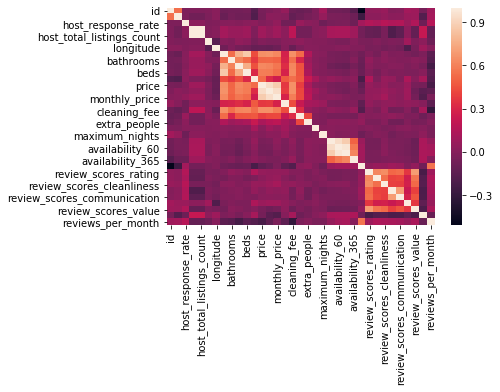

In [25]:
sns.heatmap(listings_df.corr());

In [26]:
def find_correlated_features(df,threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

In [27]:
# Drop features with > 60% correlation
corr_cols = find_correlated_features(listings_df,0.6)
corr_cols
# listings_df2 = listings_df.copy().drop(listings_df[cols_to_drop], axis=1)

['host_total_listings_count',
 'bedrooms',
 'beds',
 'price',
 'weekly_price',
 'monthly_price',
 'cleaning_fee',
 'availability_60',
 'availability_90',
 'availability_365',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_communication',
 'review_scores_value']

In [28]:
corr_cols_to_drop = ['host_total_listings_count','bedrooms','beds','weekly_price','monthly_price',
 'cleaning_fee','availability_60','availability_90','availability_365',
 'review_scores_accuracy','review_scores_communication','review_scores_value']

last_cols_to_drop = ['id','host_id','host_listings_count','host_acceptance_rate','host_neighbourhood','host_verifications','host_has_profile_pic','host_identity_verified','smart_location','calculated_host_listings_count','first_review','last_review','number_of_reviews','reviews_per_month','require_guest_profile_picture','require_guest_phone_verification','calendar_updated']

In [29]:
listings_df = listings_df.drop(corr_cols_to_drop,axis=1)
listings_df = listings_df.drop(last_cols_to_drop,axis=1)

In [30]:
listings_df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_location', 'instant_bookable',
       'cancellation_policy'],
      dtype='object')

Lastly, before we create dummies for the categorical variables, let's see how many different options there are for each of them: 

In [31]:
for col in listings_df.select_dtypes(include='object'):
    print(col + ': ' + str(len(listings_df[col].unique())))

host_response_time: 5
host_is_superhost: 3
neighbourhood: 82
neighbourhood_cleansed: 87
neighbourhood_group_cleansed: 17
zipcode: 29
property_type: 17
room_type: 3
bed_type: 5
amenities: 3284
instant_bookable: 2
cancellation_policy: 3


Since there are so many different neighbourhoods, and this information is captured in the lat/lon, let's get rid of these columns as well, and only keep `neighbourhood_group_cleansed`. Let's also get rid of zipcode since this is related to neighborhood so is captured already. 

In [32]:
listings_df = listings_df.drop(['neighbourhood','neighbourhood_cleansed','zipcode'],axis=1)

Other than that, we need to do something about the `amenities` column, since this probably has some influence on the rating, but right now there are way too many values in this to just throw it into the model as-is. Let's find a list of all the unique amenities, not a unique set of all the lists. We can do this with the newer pandas `explode` method, but first we need to clean this column so that each entry is a list, and strip out the superfluous characters such as `{`  and `}`

In [33]:
listings_df

,host_response_time,host_response_rate,host_is_superhost,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,extra_people,minimum_nights,maximum_nights,availability_30,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_location,instant_bookable,cancellation_policy
0,within a few hours,0.96,f,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,...,5.0,1,365,14,95.0,10.0,10.0,9.0,f,moderate
1,within an hour,0.98,t,Queen Anne,47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,...,0.0,2,90,13,96.0,10.0,10.0,10.0,f,strict
2,within a few hours,0.67,f,Queen Anne,47.629724,-122.369483,House,Entire home/apt,11,4.5,...,25.0,4,30,1,97.0,10.0,10.0,10.0,f,strict
3,NaN,NaN,f,Queen Anne,47.638473,-122.369279,Apartment,Entire home/apt,3,1.0,...,0.0,1,1125,0,NaN,NaN,NaN,NaN,f,flexible
4,within an hour,1.00,f,Queen Anne,47.632918,-122.372471,House,Entire home/apt,6,2.0,...,15.0,1,1125,30,92.0,9.0,10.0,9.0,f,strict
5,NaN,NaN,f,Queen Anne,47.630525,-122.366174,House,Private room,2,1.0,...,30.0,1,6,0,95.0,10.0,10.0,10.0,f,strict
6,within an hour,1.00,t,Queen Anne,47.636605,-122.368519,House,Private room,2,1.0,...,10.0,3,14,20,99.0,10.0,10.0,10.0,f,moderate
7,within an hour,1.00,t,Queen Anne,47.640161,-122.375856,Cabin,Private room,2,1.0,...,0.0,2,7,22,97.0,10.0,10.0,9.0,f,strict
8,NaN,NaN,f,Queen Anne,47.632410,-122.357216,Apartment,Private room,2,1.0,...,0.0,3,1125,6,97.0,9.0,10.0,10.0,f,strict
9,within an hour,0.98,t,Queen Anne,47.637492,-122.366889,Apartment,Entire home/apt,4,1.0,...,0.0,2,365,6,97.0,10.0,10.0,10.0,f,strict


In [34]:
# Clean amenities
clean_amenities = lambda col: col.strip('{}').split(',')
# Apply the function to the 'amenities' column
listings_df['amenities_list'] = listings_df['amenities'].apply(clean_amenities)

In [35]:
listings_df['amenities_list']

0       [TV, "Cable TV", Internet, "Wireless Internet"...
1       [TV, Internet, "Wireless Internet", Kitchen, "...
2       [TV, "Cable TV", Internet, "Wireless Internet"...
3       [Internet, "Wireless Internet", Kitchen, "Indo...
4       [TV, "Cable TV", Internet, "Wireless Internet"...
                              ...                        
3813    [TV, "Cable TV", Internet, "Wireless Internet"...
3814    [TV, "Cable TV", Internet, "Wireless Internet"...
3815    ["Cable TV", "Wireless Internet", Kitchen, "Fr...
3816    [TV, "Wireless Internet", Kitchen, "Free Parki...
3817    [TV, "Cable TV", Internet, "Wireless Internet"...
Name: amenities_list, Length: 3818, dtype: object

Using tips from this stackoverflow post, we can extract the unique values using `explode`:
https://stackoverflow.com/questions/51813266/get-unique-values-from-pandas-series-of-lists

In [36]:
listings_df['amenities_list'].explode().value_counts()

"Wireless Internet"             3667
Heating                         3627
Kitchen                         3423
"Smoke Detector"                3281
Essentials                      3237
Dryer                           2997
Washer                          2992
Internet                        2811
Shampoo                         2670
TV                              2574
"Carbon Monoxide Detector"      2485
"Fire Extinguisher"             2196
"Free Parking on Premises"      2167
"Family/Kid Friendly"           1963
"First Aid Kit"                 1680
"Cable TV"                      1446
"Indoor Fireplace"               886
"Pets live on this property"     883
Hangers                          846
"Elevator in Building"           785
"Hair Dryer"                     774
"Laptop Friendly Workspace"      745
Iron                             742
"Safety Card"                    727
"Air Conditioning"               677
"24-Hour Check-in"               616
"Buzzer/Wireless Intercom"       538
D

In [37]:
len(listings_df['amenities_list'].explode().value_counts())

42

There are still 42 unique values for the amenities, so to simplify, let's just use the # of listed amenities instead of all the different ones included. 

In [38]:
# Apply the function to the 'amenities' column
listings_df['num_amenities'] = listings_df['amenities'].apply(lambda x: len(x))

In [39]:
listings_df['num_amenities'].describe()

count    3818.000000
mean      200.060241
std        70.756117
min         2.000000
25%       155.000000
50%       198.000000
75%       245.000000
max       457.000000
Name: num_amenities, dtype: float64

In [40]:
listings_df['pet_friendly'] = listings_df['amenities'].str.contains('|'.join(['Pet','pet','Cat','Dog']))
listings_df['pet_friendly'] = listings_df['pet_friendly'].map({True: 'Yes', False: 'No'})

Now, following along the "How to Break Into The Field" Screencast and Notebook (module 11) let's take a look at some of the more prominent amenities:

In [41]:
for col in listings_df.select_dtypes(include='object'):
    try:
        print(col + ': ' + str(len(listings_df[col].unique())))
    except:
        print(col + ': n/a')

host_response_time: 5
host_is_superhost: 3
neighbourhood_group_cleansed: 17
property_type: 17
room_type: 3
bed_type: 5
amenities: 3284
instant_bookable: 2
cancellation_policy: 3
amenities_list: n/a
pet_friendly: 2


In [42]:
listings_df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'amenities', 'square_feet', 'price', 'security_deposit',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_location', 'instant_bookable',
       'cancellation_policy', 'amenities_list', 'num_amenities',
       'pet_friendly'],
      dtype='object')

This is a more reasonable number of predictors to work with. Still probably too many, but at least we have a decent start.

In [43]:
listings_df.shape

(3818, 29)

In [44]:
list(listings_df.select_dtypes(include='object').columns)

['host_response_time',
 'host_is_superhost',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'instant_bookable',
 'cancellation_policy',
 'amenities_list',
 'pet_friendly']

Let's read in the function we used to create dummy variables for the categorical variables:

In [45]:
#Create a list of the column names of the categorical variables
cat_cols_lst = list(listings_df.select_dtypes(include='object').columns)

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - boolean holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [46]:
df_dummy = create_dummy_df(listings_df, cat_cols_lst,dummy_na=True)
df_dummy.columns

Index(['host_response_rate', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'square_feet', 'price', 'security_deposit',
       'guests_included', 'extra_people',
       ...
       'amenities_{TV,Pool,Kitchen,Heating,Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Fire Extinguisher",Essentials,Shampoo,Hangers,"Hair Dryer",Iron}',
       'amenities_{}', 'amenities_nan', 'instant_bookable_t',
       'instant_bookable_nan', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'cancellation_policy_nan',
       'pet_friendly_Yes', 'pet_friendly_nan'],
      dtype='object', length=3357)

In [ ]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [ ]:
#Test function with the dataset.
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(listings_df,'review_scores_cleanliness', cat_cols_lst, dummy_na=False)
print("The r-squared train score and test score were %.2f and %.2f" % (test_score,train_score))